## Preparing the Data

In [ ]:
!mkdir data/
!mkdir data/raw
!mkdir data/processed
!mkdir data/processed/unsplash
!wget https://unsplash.com/data/lite/latest -O data/raw/unsplash.zip
!unzip data/raw/unsplash -d data/raw/unsplash
!rm data/raw/unsplash.zip

In [1]:
# imports
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch
import numpy as np
import skimage.color as color
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim


input_dir = Path("data") / "raw" / "unsplash"
output_dir = Path("data") / "processed" / "unsplash"

In [ ]:
# download the images
df = pd.read_csv(input_dir / "photos.tsv000", sep='\t', header=0)

def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
        background = Image.new("RGB", im.size, (255, 255, 255))
        background.paste(im, mask = im.split()[3])
        return background
    else:
        return im
    
def download_and_process(i):
    try:
        url = df['photo_image_url'][i]
        photo_id = df['photo_id'][i]
        im = Image.open(requests.get(url, stream=True, timeout=2).raw)
        im = remove_transparency(im)
        im.thumbnail((1000, 1000), Image.ANTIALIAS)
        im.save(output_dir / (photo_id + '.jpg'), optimize=True)
    except:
        failed.append(i)

failed = []
for i in tqdm(df.index):
    download_and_process(i)

In [ ]:
!mkdir data/processed/unsplash/train
!mkdir data/processed/unsplash/test
!mkdir data/processed/unsplash/val


all_images = list(Path(output_dir).glob("*.jpg"))
for i, img_p in enumerate(all_images):
    if i < 15000:
        os.rename(img_p, output_dir / "train" / img_p.name)
    elif i < 20000:
        os.rename(img_p, output_dir / "test" / img_p.name)
    else:
        os.rename(img_p, output_dir / "val" / img_p.name)

In [ ]:
# clean out black and white images
import os
all_images = list(Path(output_dir / 'train').glob("*.jpg")) + list(Path(output_dir / 'test').glob("*.jpg")) + list(Path(output_dir / 'val').glob("*.jpg"))
for img in tqdm(all_images):
    try:
        im = Image.open(img)
        im = np.asarray(im)
        if im.ndim != 3 or im.shape[2] == 4:
            os.remove(img)
    except:
        os.remove(img)

In [95]:
class ColorizeRGBDataset(Dataset):    
    def __init__(self, image_path, transform=None):
        self.image_names = list(Path(image_path).glob('*.jpg'))
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        rgb = Image.open(image_name)
        if self.transform:
            rgb = self.transform(rgb)
        rgb = np.asarray(rgb) / 255
        lab = color.rgb2lab(rgb)
        lab = torch.as_tensor(rgb, dtype=torch.float32).permute((2, 0, 1))
        rgb = torch.as_tensor(rgb, dtype=torch.float32).permute((2, 0, 1))
        bw = torch.unsqueeze(lab[0], 0)
        return bw, rgb

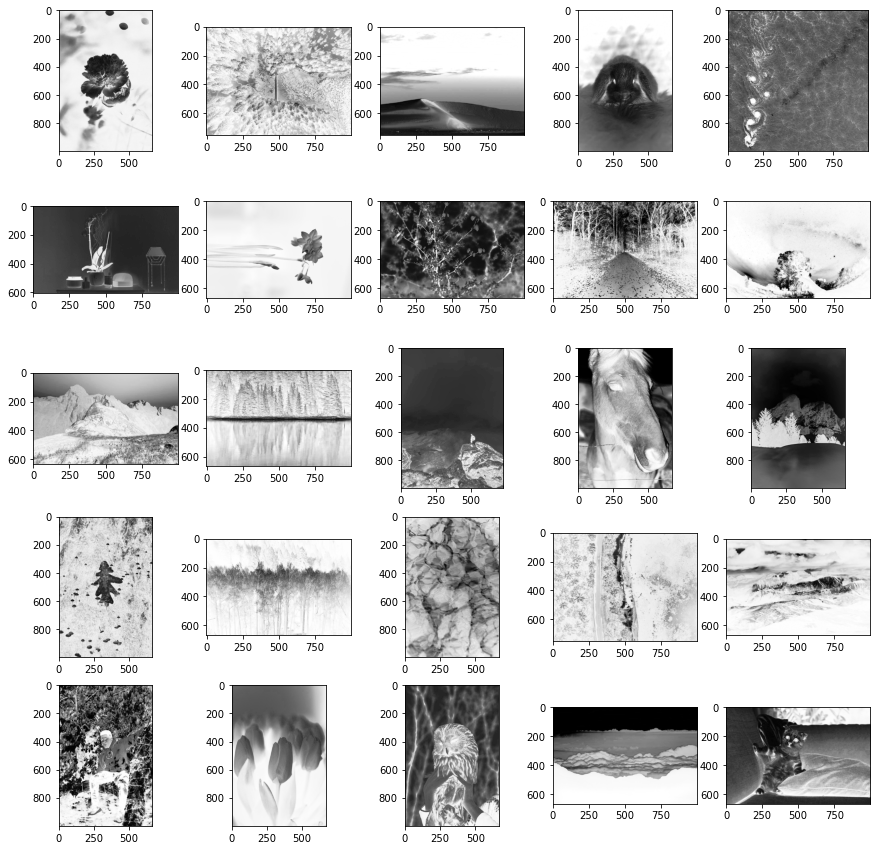

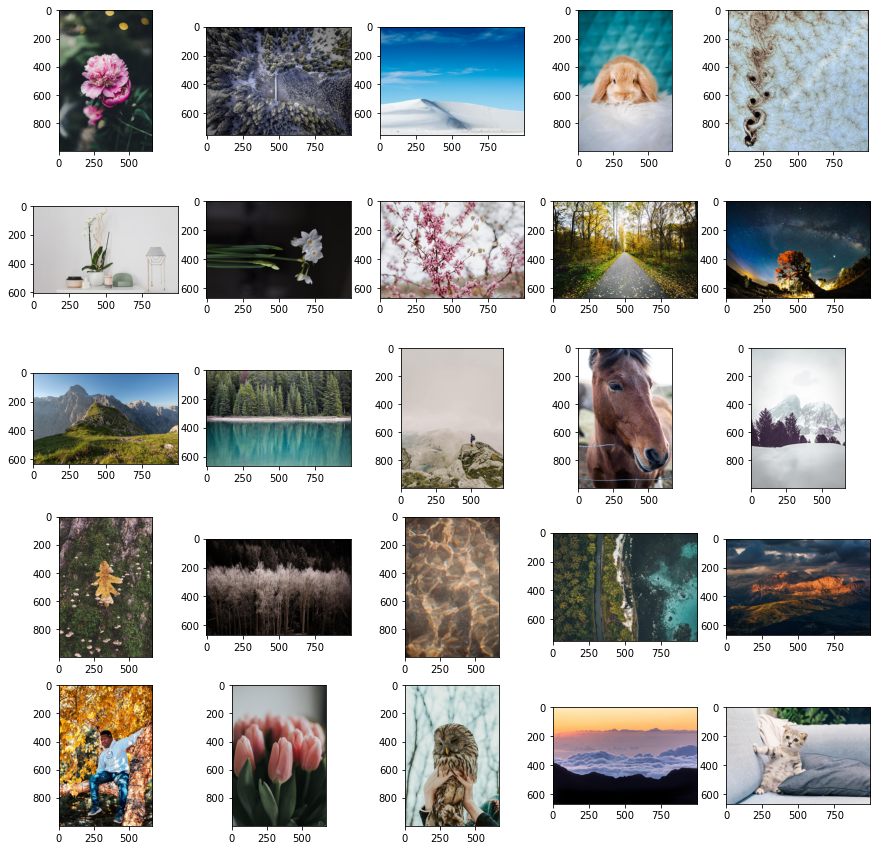

In [99]:
example_dataset = ColorizeRGBDataset(output_dir / 'train')
fig1, axes1 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
fig2, axes2 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        x, y = example_dataset[i * 5 + j]
        axes1[i][j].imshow(x[0], cmap='Greys')
        axes2[i][j].imshow(y.permute((1,2,0)))

In [137]:
class ColorizeDataset(Dataset):    
    def __init__(self, image_path, transform=None):
        self.image_names = list(Path(image_path).glob('*.jpg'))
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        im = Image.open(image_name)
        if self.transform:
            im = self.transform(im)
        im = np.asarray(im) / 255
        im = color.rgb2lab(im)
        im = torch.as_tensor(im, dtype=torch.float32).permute((2, 0, 1))
        l_channel = torch.unsqueeze(im[0], 0) / 100
        ab_channels = (im[1:] + 127) / 255
        return l_channel, ab_channels
    
    @staticmethod
    def create_lab(x, y):
        return np.concatenate([x * 100, y * 255 - 127], axis=0).transpose((1, 2, 0))
    
    @staticmethod
    def lab2rgb(lab):
        return color.lab2rgb(lab)

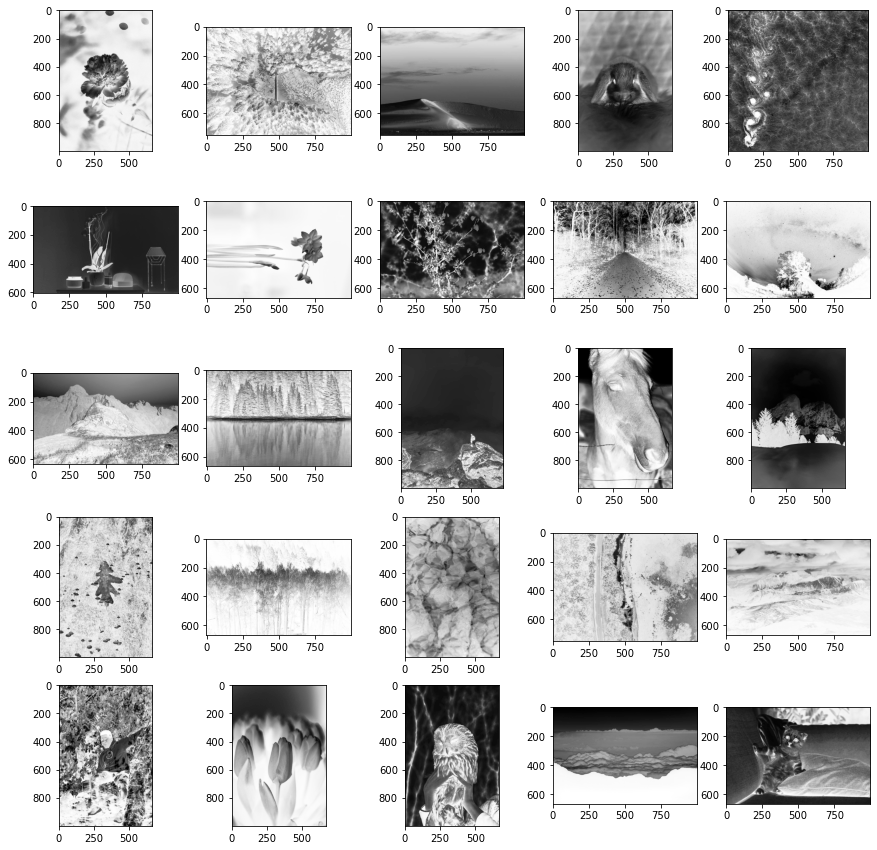

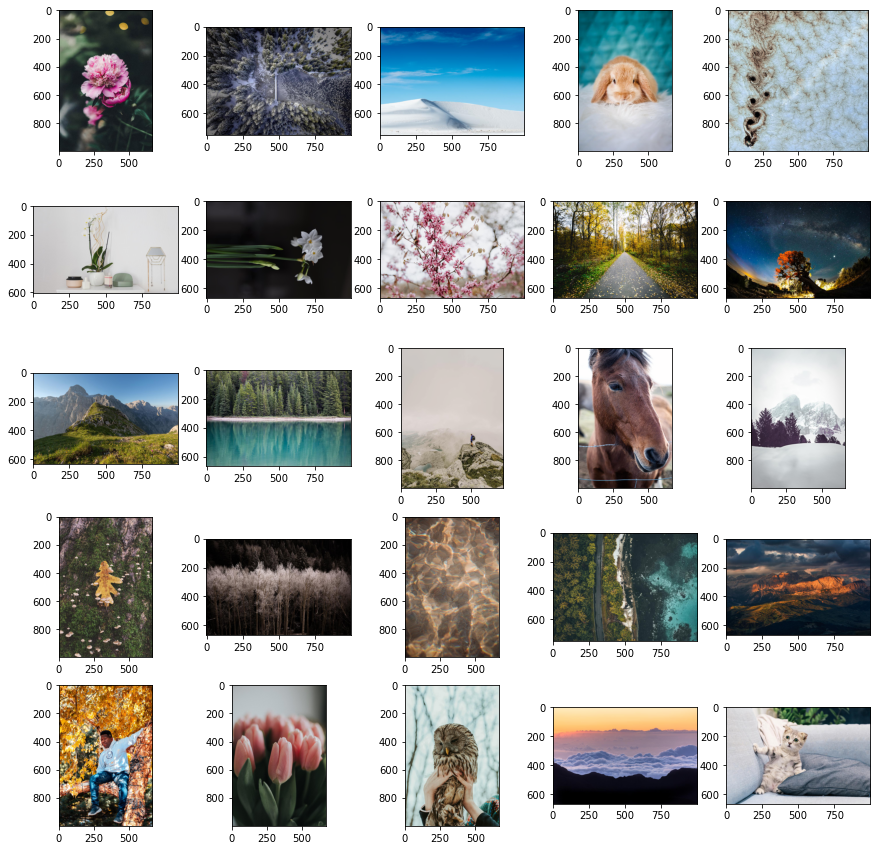

In [138]:
example_dataset = ColorizeDataset(output_dir / 'train')
fig1, axes1 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
fig2, axes2 = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i in range(5):
    for j in range(5):
        x, y = example_dataset[i * 5 + j]
        axes1[i][j].imshow(x[0], cmap='Greys')
        lab = ColorizeDataset.create_lab(x, y)
        axes2[i][j].imshow(ColorizeDataset.lab2rgb(lab))

In [10]:
class ColorizeDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage = None):
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224))
            ])
        }
        self.train = ColorizeDataset(output_dir / 'train', data_transforms['test'])
        self.val = ColorizeDataset(output_dir / 'val', data_transforms['val'])
        self.test = ColorizeDataset(output_dir / 'test', data_transforms['test'])

    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test, self.batch_size)

In [100]:
class ColorizeRGBDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage = None):
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224))
            ])
        }
        self.train = ColorizeRGBDataset(output_dir / 'train', data_transforms['test'])
        self.val = ColorizeRGBDataset(output_dir / 'val', data_transforms['val'])
        self.test = ColorizeRGBDataset(output_dir / 'test', data_transforms['test'])

    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test, self.batch_size)

In [126]:
class SanityDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=1):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        data_transforms = transforms.Compose([
                transforms.Resize((224, 224))
        ])
        self.train = ColorizeDataset(output_dir / 'sanity', data_transforms)
        
    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.train, self.batch_size)

In [101]:
class SanityDataRGBModule(pl.LightningDataModule):
    def __init__(self, batch_size=1):
        super().__init__()
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        data_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
        ])
        self.train = ColorizeRGBDataset(output_dir / 'sanity', data_transforms)
        
    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.train, self.batch_size)

In [111]:
class ResnetRGBAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        # replace first layer to take in single-channel inputs
        resnet.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        
        self.features = nn.Sequential(*list(resnet.children())[0:5]) # 256 x 56 x 56
        
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 128, 3), # 128 x 54 x 54
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 128 x 108 x 108
            nn.Conv2d(128, 64, 3), # 64 x 106 x 106
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((226, 226)), # 64 x 226 x 226
            nn.Conv2d(64, 3, 3), # 3 x 224 x 224
            nn.Sigmoid(),
        )

    def forward(self, x):
        assert(x.dim() in [3, 4])
        assert(x.shape[-1] == 224 and x.shape[-2] == 224)
        if x.dim() == 3:
            x = x.reshape(x.shape[0], 1, 224, 224)
        else: # x.dim() == 4
            assert(x.shape[1] == 1)
        
        features = self.features(x)
        return self.upsample(features)
    
    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return optimizer # [optimizer], [lr_scheduler]

In [119]:
class ResnetAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        # replace first layer to take in single-channel inputs
        resnet.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        
        self.features = nn.Sequential(*list(resnet.children())[0:5]) # 256 x 56 x 56
        
        self.upsample = nn.Sequential(
            nn.Conv2d(256, 128, 3), # 128 x 54 x 54
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # 128 x 108 x 108
            nn.Conv2d(128, 64, 3), # 64 x 106 x 106
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((226, 226)), # 64 x 226 x 226
            nn.Conv2d(64, 2, 3), # 2 x 224 x 224
            nn.Sigmoid(),
        )

    def forward(self, x):
        assert(x.dim() in [3, 4])
        assert(x.shape[-1] == 224 and x.shape[-2] == 224)
        if x.dim() == 3:
            x = x.reshape(x.shape[0], 1, 224, 224)
        else: # x.dim() == 4
            assert(x.shape[1] == 1)
        
        features = self.features(x)
        return self.upsample(features)
    
    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return optimizer #[optimizer], [lr_scheduler]

In [140]:
model = ResnetAutoEncoder()
x = torch.zeros(16, 1, 224, 224)
y = model(x)
print(y.shape)
print(y.min())
print(y.max())

torch.Size([16, 2, 224, 224])
tensor(0.0029)
tensor(0.8923)


In [160]:
class ResnetFCN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.fcn = torch.hub.load('pytorch/vision:v0.9.0', 'fcn_resnet101', pretrained=True)
        # replace first layer to take in single-channel inputs
        self.fcn.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.fcn.classifier = nn.Sequential(
            *list(self.fcn.classifier.children())[:-1],
            nn.Conv2d(512, 3, 1, 1),
            nn.Sigmoid(),
        )
        self.fcn.aux_classifier = nn.Sequential(
            *list(self.fcn.aux_classifier.children())[:-1],
            nn.Conv2d(256, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        assert(x.dim() in [3, 4])
        assert(x.shape[-1] == 224 and x.shape[-2] == 224)
        if x.dim() == 3:
            x = x.reshape(x.shape[0], 1, 224, 224)
        else: # x.dim() == 4
            assert(x.shape[1] == 1)
        
        return self.fcn(x)['out']
    
    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        # logging to TensorBoard
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-2)
        # lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return optimizer# [optimizer], [lr_scheduler]

In [166]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = ResnetFCN() # ResnetRGBAutoEncoder()
data = SanityDataRGBModule() # ColorizeDataModule(batch_size=8)

logger = pl.loggers.tensorboard.TensorBoardLogger(
    'lightning_logs', name='ResnetAutoEncoder', version=None
)

trainer = pl.trainer.Trainer(callbacks=[
    # EarlyStopping(monitor='val_loss')
], max_epochs=100, gpus=1, logger=logger, limit_val_batches=0.0)

trainer.fit(model, datamodule=data)

Using cache found in C:\Users\alexd/.cache\torch\hub\pytorch_vision_v0.9.0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | fcn  | FCN  | 54.3 M


Training: 0it [00:00, ?it/s]

1

In [ ]:
trainer.test(model, datamodule=data)

In [154]:
eval_model = model.eval().cuda(device=0)

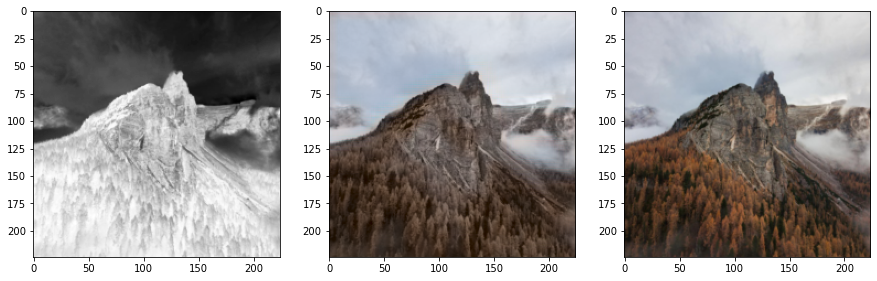

In [149]:
fig, axes = plt.subplots(ncols=3,figsize=(15,100))
x, y = data.train[0]
y_pred = eval_model(x.cuda(device=0)).cpu().detach()[0]
lab_pred = ColorizeDataset.create_lab(x, y_pred)
axes[0].imshow(x[0], cmap='Greys')
axes[1].imshow(ColorizeDataset.lab2rgb(lab_pred))
axes[2].imshow(ColorizeDataset.lab2rgb(lab_true))

In [136]:
x

tensor([[[70.1908, 69.0747, 69.0747,  ..., 87.0509, 86.8730, 86.8730],
         [70.1908, 69.8192, 69.0747,  ..., 87.0509, 86.8730, 86.8730],
         [70.9329, 70.1908, 69.0747,  ..., 87.0509, 86.8730, 86.8730],
         ...,
         [23.4755, 25.5548, 28.0893,  ..., 26.8824, 26.5337, 24.6684],
         [25.5561, 25.1603, 27.0175,  ..., 26.2624, 22.1140, 23.1861],
         [26.1034, 25.3529, 25.4993,  ..., 25.6900, 18.2649, 19.5297]]])

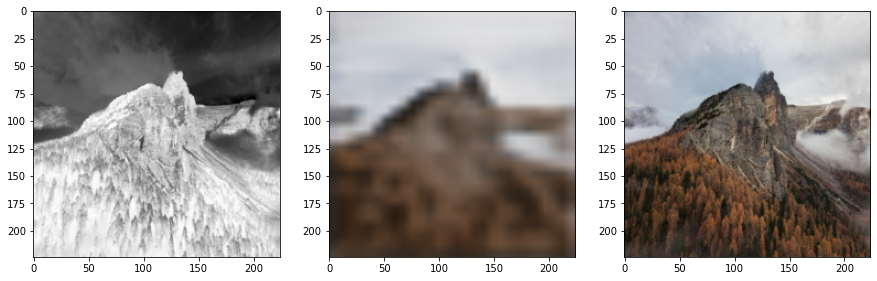

In [167]:
eval_model = model.eval().cuda(device=0)
fig, axes = plt.subplots(ncols=3,figsize=(15,5))
x, y = data.train[0]
y_pred = eval_model(x.cuda(device=0)).cpu().detach()[0]
axes[0].imshow(x[0], cmap='Greys')
axes[1].imshow(y_pred.permute((1,2,0)))
axes[2].imshow(y.permute(1,2,0))

In [157]:
y_pred.shape

torch.Size([3, 224, 224])

In [33]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(15,100))
for i in range(20):
    x, y = data.train[i]
    axes[i][0].imshow(x[0], cmap='Greys')

    y_pred = eval_model(x.cuda(device=0)).cpu().detach()[0]
    lab_pred = ColorizeDataset.create_lab(x, y_pred)
    axes[i][1].imshow(ColorizeDataset.lab2rgb(lab_pred))

    lab_true = ColorizeDataset.create_lab(x, y)
    axes[i][2].imshow(ColorizeDataset.lab2rgb(lab_true))

Exception ignored in: <function tqdm.__del__ at 0x000001C251B271F0>
Traceback (most recent call last):
  File "C:\Users\alexd\miniconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\alexd\miniconda3\lib\site-packages\tqdm\notebook.py", line 288, in close
    self.disp(close=True, check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


IndexError: list index out of range

Error in callback <function flush_figures at 0x000001C25B809700> (for post_execute):


KeyboardInterrupt: 